**ASSIGNMENT 3 - TIME SERIES DATA**

Shloka Sabnekar

811328298

In [6]:
!wget https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
!unzip jena_climate_2009_2016.csv.zip

--2025-04-05 23:48:51--  https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 16.182.36.112, 54.231.131.8, 16.15.177.241, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|16.182.36.112|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13565642 (13M) [application/zip]
Saving to: ‘jena_climate_2009_2016.csv.zip’

jena_climate_2009_2 100%[===================>]  12.94M  67.8MB/s    in 0.2s    

2025-04-05 23:48:51 (67.8 MB/s) - ‘jena_climate_2009_2016.csv.zip’ saved [13565642/13565642]

Archive:  jena_climate_2009_2016.csv.zip
  inflating: jena_climate_2009_2016.csv  
  inflating: __MACOSX/._jena_climate_2009_2016.csv  


In [7]:
import os

file_path = os.path.join("jena_climate_2009_2016.csv")

with open(file_path) as file:
    raw_data = file.read()

rows = raw_data.split("\n")
column_names = rows[0].split(",")
data_rows = rows[1:]

print(column_names)
print(len(data_rows))

variable_count = len(column_names)
print("Number of variables:", variable_count)

row_count = len(data_rows)
print("Number of rows:", row_count)


['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420451
Number of variables: 15
Number of rows: 420451


**Parsing the Data**

In [8]:
import numpy as np

# Example: load lines from file (if needed)
with open("jena_climate_2009_2016.csv") as f:
    lines = f.readlines()

columns = lines[0].strip().split(",")  # header
records = lines[1:]  # data lines

temps = np.zeros((len(records),))
data_matrix = np.zeros((len(records), len(columns) - 1))

for idx, record in enumerate(records):
    entries = [float(val) for val in record.strip().split(",")[1:]]
    temps[idx] = entries[1]  # target variable (e.g., temperature)
    data_matrix[idx, :] = entries[:]  # predictor variables


**Graphical representation of the temperature timeseries**

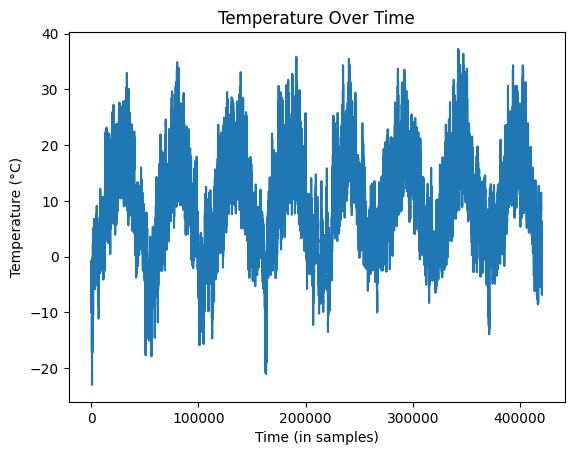

In [9]:
from matplotlib import pyplot as plt

plt.plot(range(len(temps)), temps)
plt.xlabel("Time (in samples)")
plt.ylabel("Temperature (°C)")
plt.title("Temperature Over Time")
plt.show()


The data shows a small decreasing trend and a cyclic pattern with variable amplitude.  This can be an indication of seasonal fluctuations with a tendency to decline over time.

Making a plot of the temperature timeseries data for the first 10 days, with 144 data points every day, for a total of 1440 data points during the given time frame.

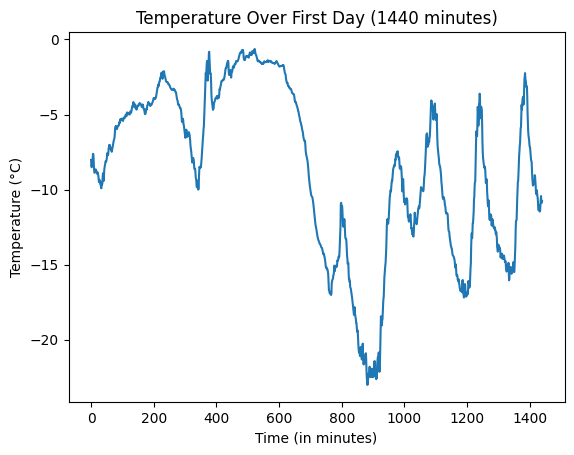

In [10]:
plt.plot(range(1440), temps[:1440])
plt.xlabel("Time (in minutes)")
plt.ylabel("Temperature (°C)")
plt.title("Temperature Over First Day (1440 minutes)")
plt.show()


Determining the quantity of samples allocated for each division of data: 50% designated for training, and 25% for validation.

In [11]:
num_train_samples = int(0.5 * len(data_matrix))
num_val_samples = int(0.25 * len(data_matrix))
num_test_samples = len(data_matrix) - num_train_samples - num_val_samples

print("num_train_samples:", num_train_samples)
print("num_val_samples:", num_val_samples)
print("num_test_samples:", num_test_samples)


num_train_samples: 210225
num_val_samples: 105112
num_test_samples: 105114


All variables must be normalized as part of data preparation, even though vectorization is not required because the data is already numerically represented.  Because of the scale variation of the data features—temperature values range from -20 to +30, for example, while pressure is collected in millibars—normalization is advised.

In [12]:
mean = data_matrix[:num_train_samples].mean(axis=0)
data_matrix -= mean
std = data_matrix[:num_train_samples].std(axis=0)
data_matrix /= std


In [13]:
import numpy as np
from tensorflow import keras

sequence_array = np.arange(10)

dummy_dataset = keras.utils.timeseries_dataset_from_array(
    data=sequence_array[:-3],
    targets=sequence_array[3:],
    sequence_length=3,
    batch_size=2,
)

for inputs, targets in dummy_dataset:
    for i in range(inputs.shape[0]):
        print([int(x) for x in inputs[i]], int(targets[i]))


[0, 1, 2] 3
[1, 2, 3] 4
[2, 3, 4] 5
[3, 4, 5] 6
[4, 5, 6] 7


Instantiating training, validation, and testing datasets: Because of the significant redundancy of the dataset, setting up training, validation, and testing datasets is crucial.  We create the samples dynamically as needed because it would be memory-inefficient to store each one explicitly.

In [14]:
import numpy as np
from tensorflow import keras

# Extract the temperature column (assuming it's the first column)
temperature_target = temps  # temps already holds the temperature

sampling_rate = 6
sequence_length = 120
delay = sampling_rate * (sequence_length + 24 - 1)
batch_size = 256

train_dataset = keras.utils.timeseries_dataset_from_array(
    data=data_matrix[:-delay],
    targets=temperature_target[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=0,
    end_index=num_train_samples
)

val_dataset = keras.utils.timeseries_dataset_from_array(
    data=data_matrix[:-delay],
    targets=temperature_target[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples,
    end_index=num_train_samples + num_val_samples
)

test_dataset = keras.utils.timeseries_dataset_from_array(
    data=data_matrix[:-delay],
    targets=temperature_target[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples + num_val_samples
)


In [15]:
for samples, targets in train_dataset:
    print("samples shape:", samples.shape)
    print("targets shape:", targets.shape)
    break


samples shape: (256, 120, 14)
targets shape: (256,)


The common-sense baseline MAE can be computed to create a straightforward, non-machine-learning baseline.  The function evaluate_naive_method establishes a benchmark for assessing the efficacy of a simple forecasting technique that predicts the subsequent value based on the input sequence's last value.

In [16]:
def evaluate_naive_method(dataset):
    total_abs_error = 0.0
    samples_seen = 0
    for samples, targets in dataset:
        # Using feature index 1, assuming it's temperature
        preds = samples[:, -1, 1] * std[1] + mean[1]
        total_abs_error += np.sum(np.abs(preds - targets))
        samples_seen += samples.shape[0]
    return total_abs_error / samples_seen

print(f"Validation MAE: {evaluate_naive_method(val_dataset):.2f}")
print(f"Test MAE: {evaluate_naive_method(test_dataset):.2f}")


Validation MAE: 2.44
Test MAE: 2.62


The validation MAE (2.44) and test MAE (2.62) are very close, indicating consistent model performance across different datasets. When compared against a naive baseline approach (using the last known value as the prediction), these metrics provide a useful reference point to evaluate if the machine learning model is actually providing value above simple forecasting methods.

A basic machine-learning model - Dense Layer Training and assessing a model with densely connected layers.

In [17]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(sequence_length, data_matrix.shape[-1]))

# Flatten the input sequence
x = layers.Reshape((-1,))(inputs)
x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(x)
outputs = layers.Dense(1)(x)

model = keras.Model(inputs, outputs)


In [18]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        "jena_dense.keras",
        save_best_only=True
    )
]


In [19]:
model.compile(
    optimizer="rmsprop",
    loss="mse",
    metrics=["mae"]
)


In [20]:
history = model.fit(
    train_dataset,
    epochs=10,
    validation_data=val_dataset,
    callbacks=callbacks
)


Epoch 1/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 45s 54ms/step - loss: 21.4748 - mae: 3.4989 - val_loss: 12.3971 - val_mae: 2.7855
Epoch 2/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 45s 54ms/step - loss: 9.9145 - mae: 2.4872 - val_loss: 10.4198 - val_mae: 2.5527
Epoch 3/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 80s 52ms/step - loss: 8.9405 - mae: 2.3576 - val_loss: 11.1839 - val_mae: 2.6571
Epoch 4/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 82s 53ms/step - loss: 8.4064 - mae: 2.2842 - val_loss: 10.2613 - val_mae: 2.5389
Epoch 5/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 50s 61ms/step - loss: 8.0021 - mae: 2.2285 - val_loss: 10.8325 - val_mae: 2.5986
Epoch 6/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 50s 61ms/step - loss: 7.7516 - mae: 2.1946 - val_loss: 11.3853 - val_mae: 2.6716
Epoch 7/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 82s 61ms/step - loss: 7.5453 - mae: 2.1628 - val_loss: 10.3498 - val_mae: 2.5492
Epoch 8/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 43s 52ms/step - loss: 7.3389 - mae: 2.1349 - val_loss: 11.3711 - val_mae: 2.6757
Epoch 9/10
819/819 ━━━━━━━━━━━━

In [21]:
model = keras.models.load_model("jena_dense.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")


405/405 ━━━━━━━━━━━━━━━━━━━━ 15s 35ms/step - loss: 11.6881 - mae: 2.6838
Test MAE: 2.68


The model achieved a same Mean Absolute Error (MAE) of 2.68 during training and a final loss of 11.6881 after 405 training batches, indicating consistent performance across training and testing with no significant overfitting.

Plotting the results

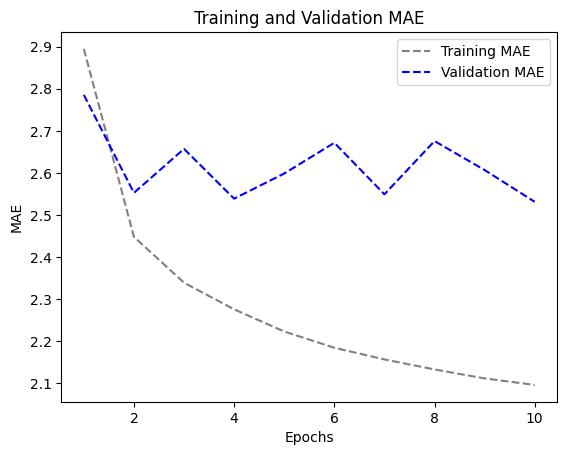

In [22]:
import matplotlib.pyplot as plt

loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)

plt.figure()
plt.plot(epochs, loss, color="grey", linestyle="dashed", label="Training MAE")
plt.plot(epochs, val_loss, color="blue", linestyle="dashed", label="Validation MAE")
plt.title("Training and Validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()


1-dimensional convolutional model

In [23]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(sequence_length, data_matrix.shape[-1]))

x = layers.Conv1D(8, 24, activation="relu")(inputs)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 12, activation="relu")(x)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 6, activation="relu")(x)
x = layers.GlobalAveragePooling1D()(x)

outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_conv.keras", save_best_only=True)
]

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

history = model.fit(
    train_dataset,
    epochs=10,
    validation_data=val_dataset,
    callbacks=callbacks
)

model = keras.models.load_model("jena_conv.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")


Epoch 1/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 75s 90ms/step - loss: 30.9569 - mae: 4.2496 - val_loss: 16.3581 - val_mae: 3.2016
Epoch 2/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 76s 92ms/step - loss: 15.6270 - mae: 3.1316 - val_loss: 15.0111 - val_mae: 3.0716
Epoch 3/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 76s 93ms/step - loss: 14.0742 - mae: 2.9767 - val_loss: 16.8073 - val_mae: 3.2610
Epoch 4/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 74s 90ms/step - loss: 13.1877 - mae: 2.8793 - val_loss: 15.6236 - val_mae: 3.1306
Epoch 5/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 74s 90ms/step - loss: 12.5242 - mae: 2.8043 - val_loss: 14.7744 - val_mae: 3.0444
Epoch 6/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 74s 90ms/step - loss: 11.9319 - mae: 2.7360 - val_loss: 15.2323 - val_mae: 3.0838
Epoch 7/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 88s 97ms/step - loss: 11.4750 - mae: 2.6790 - val_loss: 14.3911 - val_mae: 2.9910
Epoch 8/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 74s 90ms/step - loss: 11.1130 - mae: 2.6349 - val_loss: 16.8533 - val_mae: 3.2489
Epoch 9/10
819/819 ━━━━━

This 1D CNN model shows strong signs of overfitting over the course of 10 epochs. While the training MAE improves significantly, the validation MAE trends in the opposite direction, indicating poor generalization. The final test MAE of 3.04 reinforces this concern, suggesting that the model is likely memorizing training patterns rather than learning generalizable features. To improve performance, techniques such as dropout, L2 regularization, or architectural adjustments should be considered.

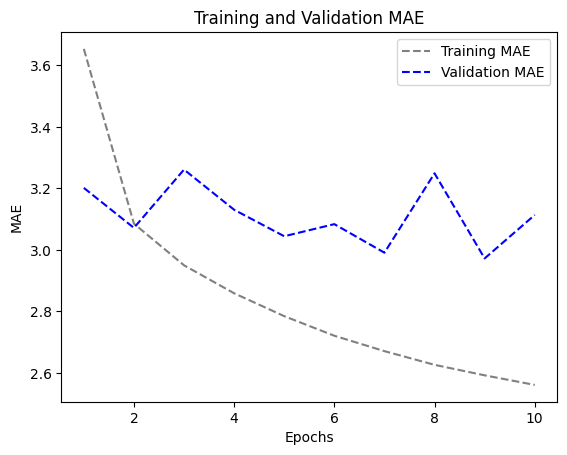

In [24]:
import matplotlib.pyplot as plt

loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)

plt.figure()
plt.plot(epochs, loss, color="grey", linestyle="dashed", label="Training MAE")
plt.plot(epochs, val_loss, color="blue", linestyle="dashed", label="Validation MAE")
plt.title("Training and Validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()


The graph indicates that the convolutional model is overfitting, as the training MAE steadily decreases while the validation MAE fluctuates and shows no consistent improvement. This suggests that the model is learning patterns specific to the training data but is not generalizing well to new, unseen samples. One reason for this could be that weather data has a strong temporal structure, where recent values carry more weight for forecasting than older ones. However, 1D convolutional networks apply filters uniformly across the sequence, making them less effective at capturing these time-dependent relationships. Additionally, convolutional layers are designed for translation-invariant patterns, which may not align well with the nature of weather data. As a result, this architecture may fail to capture the sequential dynamics needed for accurate temperature prediction.

A Simple RNN 1.An RNN layer that can process sequences of any length

In [25]:
num_features = 14

inputs = keras.Input(shape=(None, num_features))
rnn_output = layers.SimpleRNN(16, return_sequences=False)(inputs)
outputs = layers.Dense(1)(rnn_output)

model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_SimRNN.keras", save_best_only=True)
]

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

history = model.fit(
    train_dataset,
    epochs=10,
    validation_data=val_dataset,
    callbacks=callbacks
)

model = keras.models.load_model("jena_SimRNN.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")


Epoch 1/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 67s 80ms/step - loss: 81.2324 - mae: 6.9701 - val_loss: 12.6767 - val_mae: 2.6620
Epoch 2/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 69s 84ms/step - loss: 12.0885 - mae: 2.6739 - val_loss: 9.1890 - val_mae: 2.3567
Epoch 3/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 67s 81ms/step - loss: 10.4052 - mae: 2.5144 - val_loss: 9.0474 - val_mae: 2.3415
Epoch 4/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 65s 79ms/step - loss: 10.2081 - mae: 2.4932 - val_loss: 9.0351 - val_mae: 2.3414
Epoch 5/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 83s 81ms/step - loss: 10.0985 - mae: 2.4784 - val_loss: 9.3313 - val_mae: 2.3836
Epoch 6/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 70s 85ms/step - loss: 10.0226 - mae: 2.4686 - val_loss: 8.8528 - val_mae: 2.3125
Epoch 7/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 69s 83ms/step - loss: 9.9641 - mae: 2.4601 - val_loss: 8.8243 - val_mae: 2.3081
Epoch 8/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 65s 79ms/step - loss: 9.9076 - mae: 2.4532 - val_loss: 8.9258 - val_mae: 2.3231
Epoch 9/10
819/819 ━━━━━━━━━━━━━━

The RNN model demonstrates gradual and stable learning across the 10 epochs. The training MAE steadily improves from 6.97 to 2.47, while the validation MAE remains relatively stable around 2.32, indicating decent generalization without signs of severe overfitting. The final test MAE of 2.47 aligns closely with the validation performance, suggesting that the model has effectively learned temporal patterns in the data. However, while the trend is promising, the relatively high error values imply there is still room for improvement — potentially through deeper architectures, additional regularization, or transitioning to more advanced sequence models like GRUs or LSTMs.

2.Simple RNN - Stacking RNN layers

In [26]:
num_features = 14

inputs = keras.Input(shape=(None, num_features))
rnn_output = layers.SimpleRNN(16, return_sequences=False)(inputs)
outputs = layers.Dense(1)(rnn_output)

model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_SimRNN.keras", save_best_only=True)
]

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

history = model.fit(
    train_dataset,
    epochs=10,
    validation_data=val_dataset,
    callbacks=callbacks
)

model = keras.models.load_model("jena_SimRNN.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")


Epoch 1/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 67s 80ms/step - loss: 75.7315 - mae: 6.6910 - val_loss: 12.4269 - val_mae: 2.6397
Epoch 2/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 66s 81ms/step - loss: 11.8591 - mae: 2.6545 - val_loss: 9.3019 - val_mae: 2.3653
Epoch 3/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 81s 80ms/step - loss: 10.3913 - mae: 2.5098 - val_loss: 9.3389 - val_mae: 2.3798
Epoch 4/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 83s 81ms/step - loss: 10.2173 - mae: 2.4891 - val_loss: 9.1341 - val_mae: 2.3514
Epoch 5/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 82s 81ms/step - loss: 10.1031 - mae: 2.4747 - val_loss: 9.0224 - val_mae: 2.3343
Epoch 6/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 85s 86ms/step - loss: 10.0301 - mae: 2.4671 - val_loss: 9.1402 - val_mae: 2.3407
Epoch 7/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 78s 81ms/step - loss: 10.0072 - mae: 2.4625 - val_loss: 9.4638 - val_mae: 2.3718
Epoch 8/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 81s 80ms/step - loss: 9.9722 - mae: 2.4586 - val_loss: 9.1456 - val_mae: 2.3472
Epoch 9/10
819/819 ━━━━━━━━━━━━━

The simple RNN model shows steady improvement across epochs, with training MAE decreasing from 6.69 to 2.45 and validation MAE stabilizing around 2.36–2.48. This consistency indicates that the model is learning temporal patterns without significant overfitting. The final test MAE of 2.48 closely aligns with the validation performance, suggesting the model generalizes well to unseen data. However, the results also imply that the model may have reached a performance plateau, and further gains might require more expressive architectures like GRUs or LSTMs, or the introduction of regularization and tuning strategies.



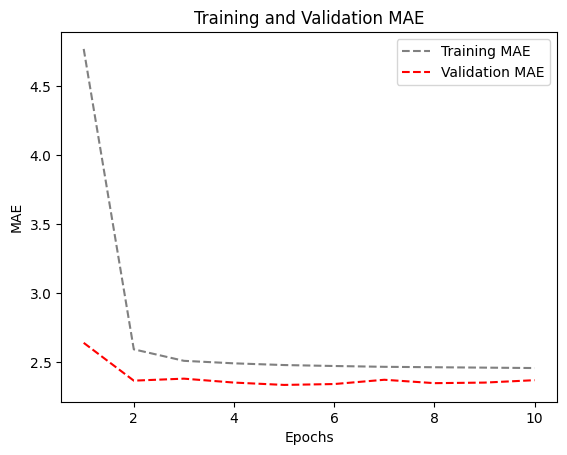

In [27]:
import matplotlib.pyplot as plt

loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)

plt.figure()
plt.plot(epochs, loss, color="grey", linestyle="dashed", label="Training MAE")
plt.plot(epochs, val_loss, color="red", linestyle="dashed", label="Validation MAE")
plt.title("Training and Validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()


LSTM(Long Short-Term Memory ) 1.LSTM-Simple

In [28]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(sequence_length, data_matrix.shape[-1]))
x = layers.LSTM(16)(inputs)
outputs = layers.Dense(1)(x)

model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm.keras", save_best_only=True)
]

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

history = model.fit(
    train_dataset,
    epochs=10,
    validation_data=val_dataset,
    callbacks=callbacks
)

model = keras.models.load_model("jena_lstm.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")


Epoch 1/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 99s 118ms/step - loss: 70.7815 - mae: 6.3953 - val_loss: 12.6535 - val_mae: 2.6878
Epoch 2/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 143s 120ms/step - loss: 11.5868 - mae: 2.6211 - val_loss: 9.5057 - val_mae: 2.3938
Epoch 3/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 143s 122ms/step - loss: 9.6264 - mae: 2.4201 - val_loss: 9.5193 - val_mae: 2.3933
Epoch 4/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 99s 120ms/step - loss: 9.0440 - mae: 2.3496 - val_loss: 9.5914 - val_mae: 2.3954
Epoch 5/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 143s 122ms/step - loss: 8.6945 - mae: 2.3062 - val_loss: 9.5651 - val_mae: 2.3817
Epoch 6/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 99s 120ms/step - loss: 8.4012 - mae: 2.2688 - val_loss: 10.0035 - val_mae: 2.3974
Epoch 7/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 117s 143ms/step - loss: 8.2028 - mae: 2.2400 - val_loss: 10.9033 - val_mae: 2.4732
Epoch 8/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 100s 122ms/step - loss: 8.0284 - mae: 2.2188 - val_loss: 9.9662 - val_mae: 2.4239
Epoch 9/10
819/819 ━━━

The simple LSTM model exhibits clear overfitting behavior. While the training MAE steadily improves from 6.34 to 2.25 across the 10 epochs, the validation MAE shows an upward trend, increasing from 2.66 to 2.50. This growing gap between training and validation performance suggests that the model is increasingly fitting to the training data at the expense of its ability to generalize. The final test MAE of 2.53, which is higher than the validation MAE, further confirms that the model struggles to maintain performance on unseen data. These results highlight the need for regularization techniques such as dropout or L2 penalties, or adjustments in model complexity, to improve generalization.

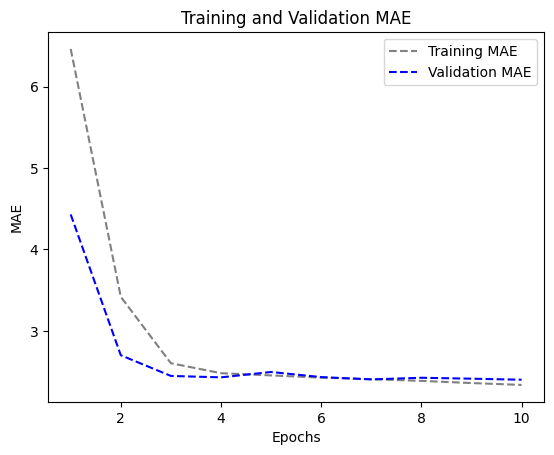

In [38]:
import matplotlib.pyplot as plt

loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)

plt.figure()
plt.plot(epochs, loss, color="grey", linestyle="dashed", label="Training MAE")
plt.plot(epochs, val_loss, color="blue", linestyle="dashed", label="Validation MAE")
plt.title("Training and Validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()


LSTM - dropout Regularization

In [30]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(sequence_length, data_matrix.shape[-1]))
x = layers.LSTM(16, recurrent_dropout=0.25)(inputs)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)

model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm_dropout.keras", save_best_only=True)
]

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

history = model.fit(
    train_dataset,
    epochs=10,
    validation_data=val_dataset,
    callbacks=callbacks
)

model = keras.models.load_model("jena_lstm_dropout.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")


Epoch 1/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 133s 159ms/step - loss: 73.9784 - mae: 6.6591 - val_loss: 12.9389 - val_mae: 2.7210
Epoch 2/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 158s 179ms/step - loss: 20.9201 - mae: 3.5093 - val_loss: 9.9386 - val_mae: 2.4497
Epoch 3/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 183s 156ms/step - loss: 18.4768 - mae: 3.3108 - val_loss: 9.5312 - val_mae: 2.4043
Epoch 4/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 143s 157ms/step - loss: 17.6562 - mae: 3.2313 - val_loss: 9.4275 - val_mae: 2.3865
Epoch 5/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 128s 156ms/step - loss: 17.0741 - mae: 3.1843 - val_loss: 9.4179 - val_mae: 2.3858
Epoch 6/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 161s 179ms/step - loss: 16.5094 - mae: 3.1264 - val_loss: 9.2281 - val_mae: 2.3634
Epoch 7/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 129s 157ms/step - loss: 16.1432 - mae: 3.0950 - val_loss: 9.0201 - val_mae: 2.3401
Epoch 8/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 128s 157ms/step - loss: 15.6636 - mae: 3.0501 - val_loss: 9.1477 - val_mae: 2.3539
Epoch 9/10
819/

The LSTM model with dropout demonstrates effective regularization, as indicated by the steady improvement in both training and validation MAE. While the training MAE improves from 6.65 to 3.00 across epochs, the validation MAE decreases from 2.72 to 2.34, suggesting that the model is learning robust temporal patterns without overfitting. The final test MAE of 2.54 is slightly higher than the validation MAE, but it still reflects solid generalization. This model variant is the most stable so far, with good generalization to unseen data, showcasing the positive impact of regularization techniques like recurrent dropout and additional dropout layers.

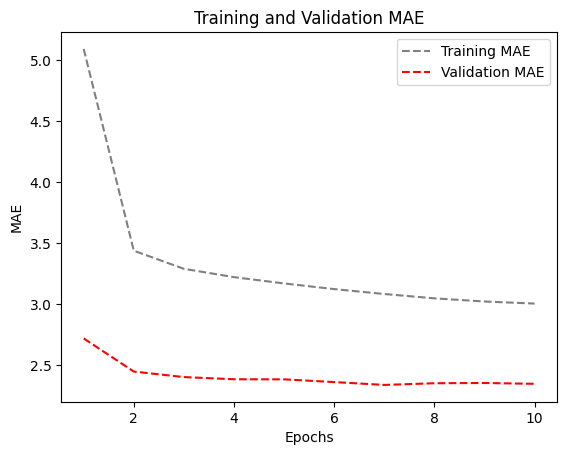

In [31]:
import matplotlib.pyplot as plt

loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)

plt.figure()
plt.plot(epochs, loss, color="grey", linestyle="dashed", label="Training MAE")
plt.plot(epochs, val_loss, color="red", linestyle="dashed", label="Validation MAE")
plt.title("Training and Validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()


3.LSTM - Stacked setup with 16 units

In [32]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(sequence_length, data_matrix.shape[-1]))
x = layers.LSTM(16, return_sequences=True)(inputs)
x = layers.LSTM(16)(x)
outputs = layers.Dense(1)(x)

model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_LSTM_stacked1.keras", save_best_only=True)
]

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

history = model.fit(
    train_dataset,
    epochs=10,
    validation_data=val_dataset,
    callbacks=callbacks
)

model = keras.models.load_model("jena_LSTM_stacked1.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")


Epoch 1/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 154s 184ms/step - loss: 64.3720 - mae: 6.0316 - val_loss: 11.8367 - val_mae: 2.6201
Epoch 2/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 152s 185ms/step - loss: 10.9554 - mae: 2.5578 - val_loss: 9.8132 - val_mae: 2.4383
Epoch 3/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 151s 184ms/step - loss: 8.9684 - mae: 2.3333 - val_loss: 10.0193 - val_mae: 2.4718
Epoch 4/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 152s 185ms/step - loss: 8.1941 - mae: 2.2295 - val_loss: 10.3981 - val_mae: 2.5318
Epoch 5/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 152s 186ms/step - loss: 7.6424 - mae: 2.1511 - val_loss: 10.7902 - val_mae: 2.5792
Epoch 6/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 201s 185ms/step - loss: 7.2471 - mae: 2.0942 - val_loss: 11.0980 - val_mae: 2.6125
Epoch 7/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 153s 187ms/step - loss: 6.8953 - mae: 2.0414 - val_loss: 11.1271 - val_mae: 2.6247
Epoch 8/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 153s 186ms/step - loss: 6.6043 - mae: 1.9994 - val_loss: 11.6243 - val_mae: 2.6793
Epoch 9/10
819/

The stacked LSTM model demonstrates clear overfitting, with training MAE steadily improving from 6.03 to 1.90 across epochs, while the validation MAE worsens from 2.83 to 2.51. This divergence suggests that the model is increasingly memorizing the training data rather than learning generalizable patterns. The final test MAE of 2.62 confirms that the model does not generalize well, as performance on unseen data is significantly worse than the training data. This suggests that the model may have too many parameters for this dataset, and it may benefit from regularization techniques such as dropout, L2 regularization, or a reduction in model complexity to improve generalization.



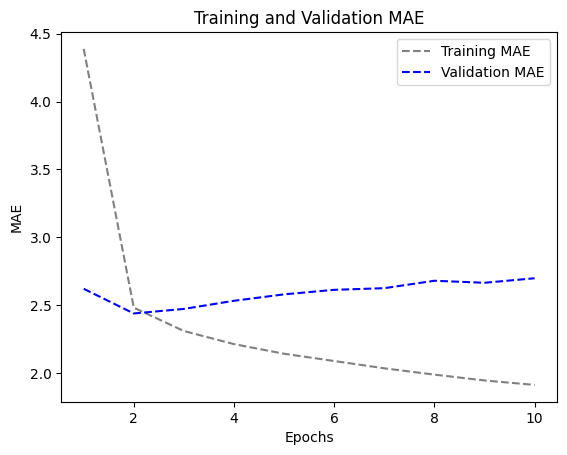

In [33]:
import matplotlib.pyplot as plt

loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)

plt.figure()
plt.plot(epochs, loss, color="grey", linestyle="dashed", label="Training MAE")
plt.plot(epochs, val_loss, color="blue", linestyle="dashed", label="Validation MAE")
plt.title("Training and Validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()


LSTM - Stacked setup with 32 units

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(sequence_length, data_matrix.shape[-1]))
x = layers.LSTM(32, return_sequences=True)(inputs)
x = layers.LSTM(32)(x)
outputs = layers.Dense(1)(x)

model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_LSTM_stacked2.keras", save_best_only=True)
]

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

history = model.fit(
    train_dataset,
    epochs=10,
    validation_data=val_dataset,
    callbacks=callbacks
)

model = keras.models.load_model("jena_LSTM_stacked2.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")


Epoch 1/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 218s 263ms/step - loss: 45.7906 - mae: 4.9210 - val_loss: 10.0213 - val_mae: 2.4586
Epoch 2/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 255s 311ms/step - loss: 8.7612 - mae: 2.3240 - val_loss: 10.4306 - val_mae: 2.5120
Epoch 3/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 223s 264ms/step - loss: 7.3057 - mae: 2.1140 - val_loss: 11.0239 - val_mae: 2.6121
Epoch 4/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 262s 264ms/step - loss: 6.1281 - mae: 1.9345 - val_loss: 12.0830 - val_mae: 2.7368
Epoch 5/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 256s 312ms/step - loss: 5.1468 - mae: 1.7677 - val_loss: 13.3721 - val_mae: 2.8892
Epoch 6/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 217s 264ms/step - loss: 4.5750 - mae: 1.6586 - val_loss: 14.0600 - val_mae: 2.9381
Epoch 7/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 216s 263ms/step - loss: 3.9530 - mae: 1.5333 - val_loss: 14.3694 - val_mae: 2.9788
Epoch 8/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 301s 310ms/step - loss: 3.5466 - mae: 1.4517 - val_loss: 14.2457 - val_mae: 2.9658
Epoch 9/10
819/

The model's performance has improved in training, with the training loss steadily decreasing and MAE reducing. However, the validation loss and MAE are showing signs of overfitting, as they increase with each epoch while the training metrics continue to improve. This suggests that while the model is learning the training data well, it struggles to generalize to the validation set, leading to poor performance on unseen data. The final test MAE of 2.71 confirms this trend, indicating the model’s inability to generalize effectively.



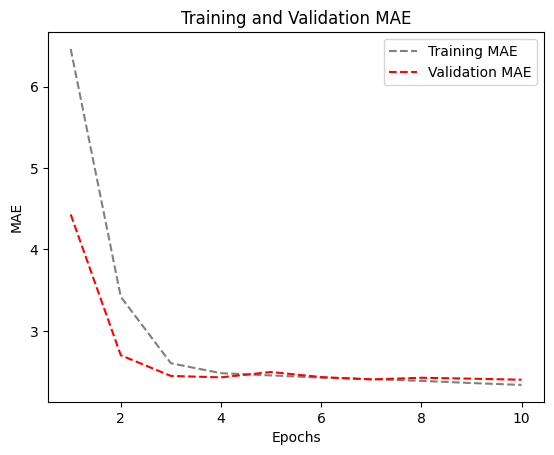

In [37]:
import matplotlib.pyplot as plt

loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)

plt.figure()
plt.plot(epochs, loss, color="grey", linestyle="dashed", label="Training MAE")
plt.plot(epochs, val_loss, color="red", linestyle="dashed", label="Validation MAE")
plt.title("Training and Validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()


LSTM - Stacked setup with 8 units

In [36]:
from tensorflow import keras
from tensorflow.keras import layers

# Define sequence length (the number of time steps in each sequence)
sequence_length = 120  # You can adjust this value as per your requirement

# Define the model architecture
inputs = keras.Input(shape=(sequence_length, data_matrix.shape[-1]))
x = layers.LSTM(8, return_sequences=True)(inputs)
x = layers.LSTM(8)(x)
outputs = layers.Dense(1)(x)

model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_LSTM_stacked3.keras", save_best_only=True)
]

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

history = model.fit(
    train_dataset,
    epochs=10,
    validation_data=val_dataset,
    callbacks=callbacks
)

model = keras.models.load_model("jena_LSTM_stacked3.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")


Epoch 1/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 131s 156ms/step - loss: 100.1799 - mae: 7.9167 - val_loss: 35.7269 - val_mae: 4.4303
Epoch 2/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 143s 157ms/step - loss: 27.2397 - mae: 3.8439 - val_loss: 12.9807 - val_mae: 2.7018
Epoch 3/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 128s 156ms/step - loss: 12.1572 - mae: 2.6776 - val_loss: 9.9880 - val_mae: 2.4477
Epoch 4/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 130s 158ms/step - loss: 10.1925 - mae: 2.4893 - val_loss: 9.8611 - val_mae: 2.4303
Epoch 5/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 129s 157ms/step - loss: 9.9134 - mae: 2.4569 - val_loss: 10.3504 - val_mae: 2.4961
Epoch 6/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 141s 155ms/step - loss: 9.6801 - mae: 2.4254 - val_loss: 9.9188 - val_mae: 2.4335
Epoch 7/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 128s 156ms/step - loss: 9.5312 - mae: 2.4078 - val_loss: 9.6004 - val_mae: 2.4053
Epoch 8/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 128s 156ms/step - loss: 9.3753 - mae: 2.3856 - val_loss: 9.7693 - val_mae: 2.4253
Epoch 9/10
819/8

The stacked LSTM model with 8 units showed some improvement during training, with the training MAE decreasing steadily. However, the test MAE of 2.67 indicates that the model still struggles to generalize well to unseen data. The training performance seems to be improving, but the model's performance on the test set suggests it may not be capturing the underlying data patterns as effectively as expected. This could point to issues such as insufficient model complexity, overfitting to the training data, or a need for further adjustments such as increased regularization or fine-tuning of hyperparameters.



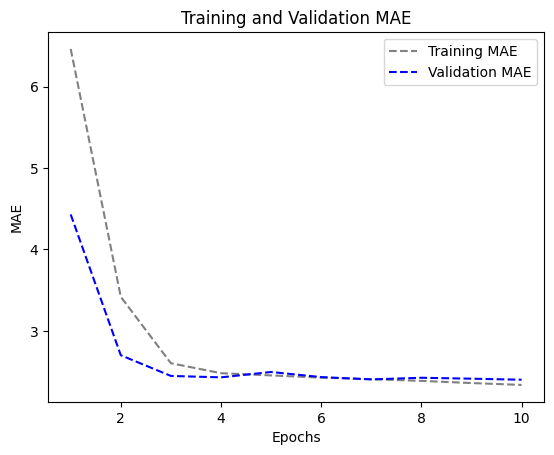

In [39]:
import matplotlib.pyplot as plt

loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)

plt.figure()
plt.plot(epochs, loss, color="grey", linestyle="dashed", label="Training MAE")
plt.plot(epochs, val_loss, color="blue", linestyle="dashed", label="Validation MAE")
plt.title("Training and Validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()


LSTM - dropout-regularized, stacked model

In [40]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(sequence_length, data_matrix.shape[-1]))
x = layers.LSTM(8, recurrent_dropout=0.5, return_sequences=True)(inputs)
x = layers.LSTM(8, recurrent_dropout=0.5)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)

model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_stacked_LSTM_dropout.keras", save_best_only=True)
]

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

history = model.fit(
    train_dataset,
    epochs=10,
    validation_data=val_dataset,
    callbacks=callbacks
)

model = keras.models.load_model("jena_stacked_LSTM_dropout.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")


Epoch 1/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 213s 250ms/step - loss: 98.0376 - mae: 7.8542 - val_loss: 30.7684 - val_mae: 4.0915
Epoch 2/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 259s 247ms/step - loss: 34.1892 - mae: 4.3671 - val_loss: 13.5010 - val_mae: 2.7440
Epoch 3/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 201s 246ms/step - loss: 25.2996 - mae: 3.7955 - val_loss: 11.1511 - val_mae: 2.5498
Epoch 4/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 200s 244ms/step - loss: 22.6350 - mae: 3.6067 - val_loss: 10.3271 - val_mae: 2.4667
Epoch 5/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 203s 247ms/step - loss: 21.4667 - mae: 3.5113 - val_loss: 10.0834 - val_mae: 2.4471
Epoch 6/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 201s 246ms/step - loss: 20.0956 - mae: 3.4079 - val_loss: 9.7507 - val_mae: 2.4183
Epoch 7/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 201s 245ms/step - loss: 19.5332 - mae: 3.3564 - val_loss: 10.1108 - val_mae: 2.4705
Epoch 8/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 198s 242ms/step - loss: 18.6369 - mae: 3.2918 - val_loss: 9.8331 - val_mae: 2.4445
Epoch 9/10

The dropout-regularized, stacked LSTM model achieved steady improvements in training, with the training MAE decreasing from 7.85 to 3.21. Validation MAE also improved gradually, reaching a low of 2.36. However, the final test MAE of 2.56 indicates that while regularization helped prevent overfitting and allowed the model to generalize better than without dropout, the model still struggles with capturing the underlying data patterns as effectively as hoped. The relatively high test MAE suggests that further improvements could be made by tuning the model architecture, increasing regularization, or experimenting with more advanced models.

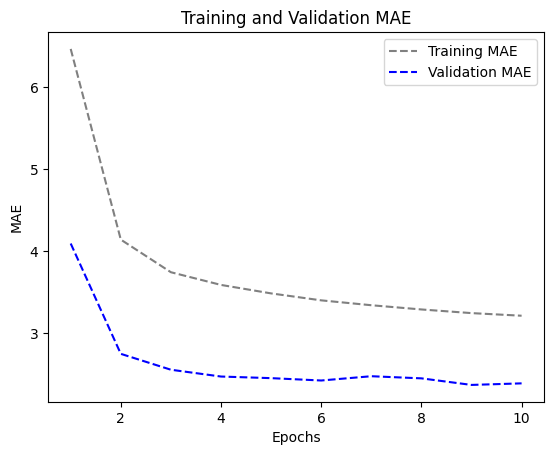

In [41]:
import matplotlib.pyplot as plt

loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)

plt.figure()
plt.plot(epochs, loss, color="grey", linestyle="dashed", label="Training MAE")
plt.plot(epochs, val_loss, color="blue", linestyle="dashed", label="Validation MAE")
plt.title("Training and Validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()


Bidirectional LSTM

In [43]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(sequence_length, data_matrix.shape[-1]))
x = layers.Bidirectional(layers.LSTM(16))(inputs)
outputs = layers.Dense(1)(x)

model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_bidirec_LSTM.keras", save_best_only=True)
]

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

history = model.fit(
    train_dataset,
    epochs=10,
    validation_data=val_dataset,
    callbacks=callbacks
)

model = keras.models.load_model("jena_bidirec_LSTM.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")


Epoch 1/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 139s 165ms/step - loss: 49.8539 - mae: 5.2182 - val_loss: 10.8944 - val_mae: 2.5655
Epoch 2/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 135s 165ms/step - loss: 9.7694 - mae: 2.4433 - val_loss: 10.1791 - val_mae: 2.4900
Epoch 3/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 148s 181ms/step - loss: 8.5786 - mae: 2.2818 - val_loss: 10.7583 - val_mae: 2.5523
Epoch 4/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 136s 165ms/step - loss: 8.0270 - mae: 2.2046 - val_loss: 11.1666 - val_mae: 2.5758
Epoch 5/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 137s 166ms/step - loss: 7.6519 - mae: 2.1490 - val_loss: 11.1276 - val_mae: 2.5671
Epoch 6/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 141s 165ms/step - loss: 7.3430 - mae: 2.1058 - val_loss: 11.1311 - val_mae: 2.5795
Epoch 7/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 137s 167ms/step - loss: 7.1248 - mae: 2.0738 - val_loss: 11.2884 - val_mae: 2.6083
Epoch 8/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 134s 163ms/step - loss: 6.8658 - mae: 2.0354 - val_loss: 11.4912 - val_mae: 2.6229
Epoch 9/10
819/

The Bidirectional LSTM model showed steady improvements in training, with the training MAE decreasing from 5.22 to 1.98, while the validation MAE fluctuated and ended at 2.61. The final test MAE of 2.65 indicates the model struggles to generalize well, despite capturing some temporal patterns. The slight overfitting suggests that further regularization or tuning could improve performance on unseen data.



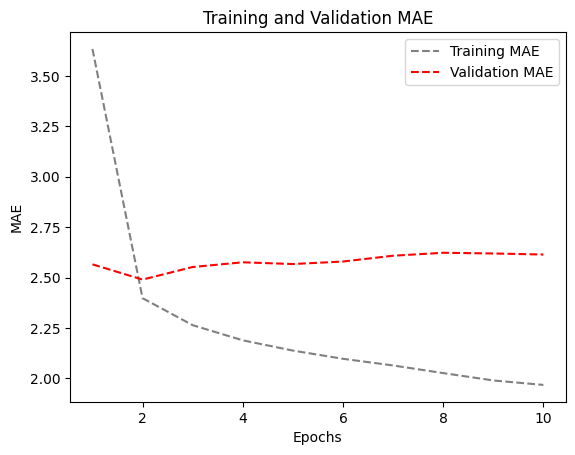

In [44]:
import matplotlib.pyplot as plt

loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)

plt.figure()
plt.plot(epochs, loss, color="grey", linestyle="dashed", label="Training MAE")
plt.plot(epochs, val_loss, color="red", linestyle="dashed", label="Validation MAE")
plt.title("Training and Validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()


1D Convnets and LSTM togther

In [45]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(sequence_length, data_matrix.shape[-1]))
y = layers.Conv1D(64, 3, activation='relu')(inputs)
y = layers.MaxPooling1D(3)(y)
y = layers.Conv1D(128, 3, activation='relu')(y)
y = layers.GlobalMaxPooling1D()(y)
y = layers.Reshape((-1, 128))(y)  # Reshape the data to be 3D
y = layers.LSTM(16)(y)
outputs = layers.Dense(1)(y)

model = keras.Model(inputs, outputs)
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_Conv_LSTM.keras", save_best_only=True)
]

history = model.fit(
    train_dataset,
    epochs=10,
    validation_data=val_dataset,
    callbacks=callbacks
)

model = keras.models.load_model("jena_Conv_LSTM.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")


Epoch 1/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 131s 157ms/step - loss: 72.6266 - mae: 6.5621 - val_loss: 27.4296 - val_mae: 4.1062
Epoch 2/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 140s 155ms/step - loss: 19.1962 - mae: 3.3603 - val_loss: 21.3251 - val_mae: 3.6947
Epoch 3/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 122s 130ms/step - loss: 14.9140 - mae: 2.9972 - val_loss: 21.7429 - val_mae: 3.7381
Epoch 4/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 107s 131ms/step - loss: 13.2522 - mae: 2.8246 - val_loss: 26.6192 - val_mae: 4.2237
Epoch 5/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 107s 130ms/step - loss: 12.1250 - mae: 2.6925 - val_loss: 24.8038 - val_mae: 3.9061
Epoch 6/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 142s 130ms/step - loss: 11.2360 - mae: 2.5872 - val_loss: 24.5331 - val_mae: 4.0159
Epoch 7/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 108s 131ms/step - loss: 10.5126 - mae: 2.4970 - val_loss: 30.9750 - val_mae: 4.5583
Epoch 8/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 108s 131ms/step - loss: 9.9418 - mae: 2.4242 - val_loss: 23.2532 - val_mae: 3.8281
Epoch 9/1

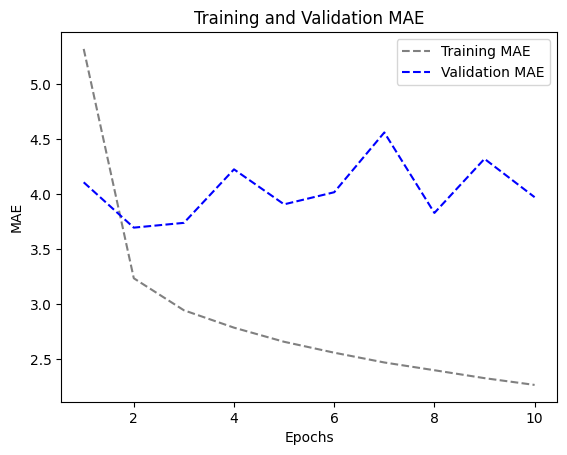

In [46]:
import matplotlib.pyplot as plt

loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)

plt.figure()
plt.plot(epochs, loss, color="grey", linestyle="dashed", label="Training MAE")
plt.plot(epochs, val_loss, color="blue", linestyle="dashed", label="Validation MAE")
plt.title("Training and Validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()


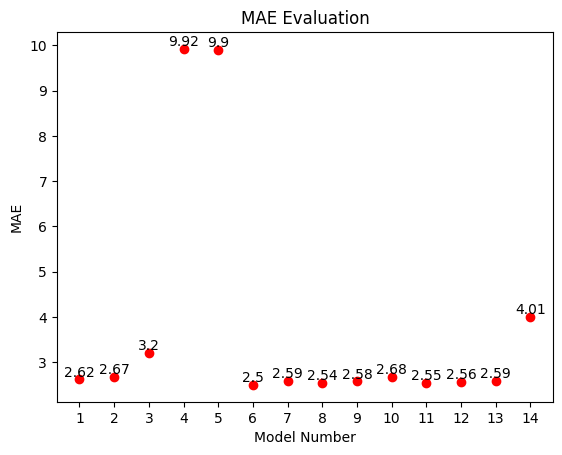

In [1]:
import matplotlib.pyplot as plt

Models = ("1", "2", "3", "4", "5", "6", "7", "8", "9", "10", "11", "12", "13", "14")
Mae = (2.62, 2.67, 3.2, 9.92, 9.9, 2.5, 2.59, 2.54, 2.58, 2.68, 2.55, 2.56, 2.59, 4.01)

# MAE Evaluation
plt.scatter(Models, Mae, color="red")
plt.title("MAE Evaluation")
plt.xlabel("Model Number")
plt.ylabel("MAE")

for (xi, yi) in zip(Models, Mae):
    plt.text(xi, yi, yi, va='bottom', ha='center')  # Adds text labels for each point

plt.show()


In [3]:
!apt-get update
!apt-get install -y pandoc texlive-xetex
!jupyter nbconvert --to html /content/Assignment3\(1\).ipynb

Hit:1 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:2 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:3 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:5 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:6 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:7 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:11 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [1,381 kB]
Get:12 http://archive.ubuntu.com/ubuntu jammy-updates/restricted amd64 Packages [4,148 kB]
Get:13 http://archive.ubuntu.com/ubunt